In [1]:
### imports
import numpy as np
import pandas as pd
import ast
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.base import clone

import sys

sys.path.append("..")
sys.path.append("../src")

from src.datahandling.loading import load_data  # loading
import src.datahandling.visualization as vis  # plotting
from src.models.xgb import XGB
from src.datahandling.preprocessing import (
    DataCleaner,
    SupervisedTransformer,
    FeatureSelector,
    Normalizer,
    train_test_split,
)  # preprocessing

### load benchmarks
benchmarks = pd.read_csv("../results/benchmarks.csv")

# XG-Boost Regression

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. 


Since we found in `notebooks/RegressionVariants.ipynb` that feature selection does not influence the performance of the regression models, we will stick with the features that are contained in both data sets.

In [2]:
model = Pipeline(
    [
        ("norm", Normalizer()),
        ("st", SupervisedTransformer(encode_time=["hour", "month"])),
        ("xgb", XGB()),
    ]
)

param_grid = {
    "st__window_size": [8],
    "st__horizon": ["10min", "hourly", "daily"],
    "xgb__learning_rate": [0.01, 0.1, 0.2, 0.3],
    "xgb__n_estimators": [100, 300, 500],
    "xgb__max_depth": [3, 4, 5, 6],
    "xgb__min_child_weight": [1, 2, 3, 4],
}

## British Dataset - Kelmarsh

In [ ]:
### loading data
TURBINE_ID = 2
data_brit = load_data(turbine_id=TURBINE_ID, which_data="British")

### cleaning  data
cleaner = DataCleaner(
    features=[
        "Power (kW)",
        "Wind speed (m/s)",
        "Wind direction (°)",
        "Rotor speed (RPM)",
    ],
    rename_features=[
        "power",
        "wind_speed",
        "wind_direction",
        "rotor_speed",
    ],
)
data_brit = cleaner.transform(data_brit)

# create train and test set (exactly as used in the benchmarks)
test_start = benchmarks["test_start"][0]
test_end = benchmarks["test_end"][0]
X_train, y_train, X_test, y_test = train_test_split(
    df=data_brit, test_start=test_start, test_end=test_end, target_var="power"
)

In [ ]:
### hyperparameter tuning
### RUNTIME: ~6 min on my machine
do_gridsearch = False

if do_gridsearch:

    grid_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=TimeSeriesSplit(n_splits=3),
        verbose=2,
        n_jobs=-1,
        n_iter=15,
        refit=False,
    )

    grid_search.fit(X_train, y_train)
    res_gs_brit = pd.DataFrame(grid_search.cv_results_)
    ### store results in csv-file
    pd.DataFrame(res_gs_brit).to_csv("../results/results_gs_xgb_brit.csv")
    # reload necessary 
    res_gs_brit = pd.read_csv("../results/results_gs_xgb_brit.csv")
else:
    res_gs_brit = pd.read_csv("../results/results_gs_xgb_brit.csv")

In [ ]:
vis.plot_gridsearch_results(
    res_gs_brit, x="param_st__horizon", hue="param_st__window_size", col=None
)

In [ ]:
### extract best parameters of each model for each horizon
best_params_brit_xgb = (
    res_gs_brit.set_index(["params"])[["mean_test_score", "param_st__horizon"]]
    .groupby("param_st__horizon")
    .idxmax()
)

# print best parameters for each horizon
for horizon in best_params_brit_xgb.index:
    print(
        f"Best parameters for horizon {horizon}: {ast.literal_eval(best_params_brit_xgb.loc[horizon][0])}"
    )

## Brazilian Dataset - Beberine

In [3]:
### loading data
TURBINE_ID = 1
data_braz = load_data(turbine_id=TURBINE_ID, which_data="Brazilian")

### cleaning data 
cleaner = DataCleaner(
    features=[
        "active_power_total",
        "wind_speed",
        "wind_direction",
        "rotor_rpm",
    ],
    rename_features=[
        "power",
        "wind_speed",
        "wind_direction",
        "rotor_speed",
    ],
)
data_braz = cleaner.transform(data_braz)

# create train and test set (exactly as used in the benchmarks)
test_start = benchmarks["test_start"][3]
test_end = benchmarks["test_end"][3]
X_train, y_train, X_test, y_test = train_test_split(
    df=data_braz, test_start=test_start, test_end=test_end, target_var="power"
)

In [4]:
### hyperparameter tuning
### RUNTIME: ~ 10 min on my machine
do_gridsearch = False

if do_gridsearch:
    grid_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=TimeSeriesSplit(n_splits=3),
        verbose=2,
        n_jobs=-1,
        n_iter=15, 
        refit=False,
    )
    grid_search.fit(X_train, y_train)
    res_gs_braz = pd.DataFrame(grid_search.cv_results_)
    ### store results in csv-file
    pd.DataFrame(res_gs_braz).to_csv("../results/results_gs_xgb_braz.csv")
    # reload sometimes necessary for data type reasons
    res_gs_braz = pd.read_csv("../results/results_gs_xgb_braz.csv")
else:
    res_gs_braz = pd.read_csv("../results/results_gs_xgb_braz.csv")

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


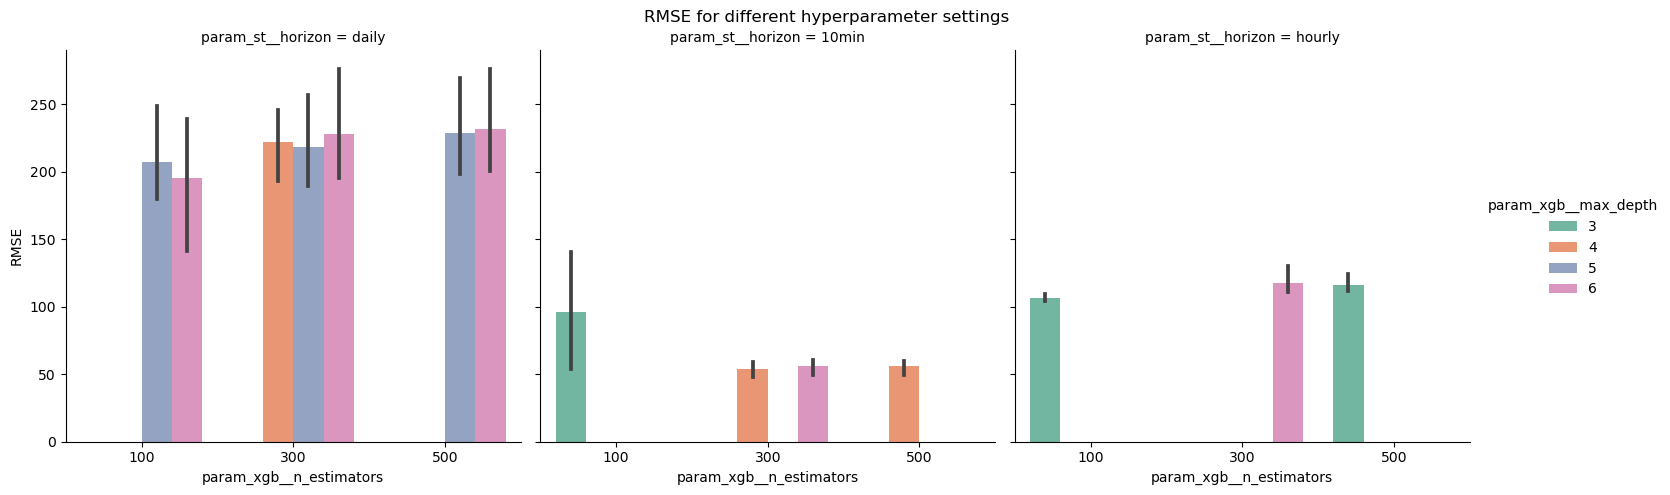

In [5]:
vis.plot_gridsearch_results(res_gs_braz, x="param_xgb__n_estimators", hue="param_xgb__max_depth")

In [7]:
### extract best parameters of each model for each horizon
best_params_braz_xgb = (
    res_gs_braz.set_index(["params"])[["mean_test_score", "param_st__horizon"]]
    .groupby("param_st__horizon")
    .idxmax()
)

# print best parameters for each horizon
for horizon in best_params_braz_xgb.index:
    print(
        f"Best parameters for horizon {horizon}: {ast.literal_eval(best_params_braz_xgb.loc[horizon][0])}"
    )

Best parameters for horizon 10min: {'xgb__n_estimators': 100, 'xgb__min_child_weight': 2, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.3, 'st__window_size': 8, 'st__horizon': '10min'}
Best parameters for horizon daily: {'xgb__n_estimators': 100, 'xgb__min_child_weight': 1, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.01, 'st__window_size': 8, 'st__horizon': 'daily'}
Best parameters for horizon hourly: {'xgb__n_estimators': 100, 'xgb__min_child_weight': 4, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.2, 'st__window_size': 8, 'st__horizon': 'hourly'}


In [8]:
### plot predictions for best models
# refit models
models = {}
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    models[horizon] = clone(model).set_params(
        **ast.literal_eval(best_params_braz_xgb.loc[horizon][0])
    )
    models[horizon].fit(X_train, y_train)
    predictions[horizon] = models[horizon].predict(X_test)
predictions = pd.DataFrame(predictions, index=X_test.index)

: 

In [ ]:
# plot first 3000 predictions
vis.plot_predictions(predictions[:3000], y_test[:3000])